In [1]:
# load modules etc
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


In [2]:

# Paths (absolute for exploration)

image_dir = r"C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Health Imaging\data\raw\images\images"
labels_path = r"C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Health Imaging\data\raw\images\sample_labels.csv"


In [3]:

# Sanity check: list first 5 image names

os.listdir(image_dir)[:5]

['00000013_005.png',
 '00000013_026.png',
 '00000017_001.png',
 '00000030_001.png',
 '00000032_001.png']

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

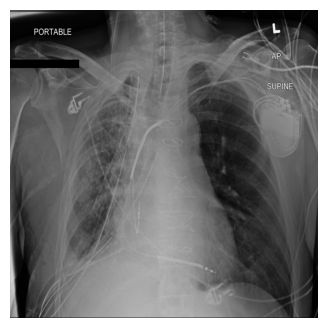

In [4]:

# Load and display one image

image_name = os.listdir(image_dir)[0]
image_path = os.path.join(image_dir, image_name)

img = Image.open(image_path)

plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray")
plt.axis("off")



In [5]:

# Load labels

labels_df = pd.read_csv(labels_path)
labels_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [ ]:
# image index -index to link csv labels to image
# finding labels - clinical findings present in the xray
# follow up - number of x ray exams patient has had, 0 = first recorded exam, larger numbers - later follow ups
# patient ID - anonymised identifier, helps link multiple xrays to one patient
# patient age - age of patient in years
# patient gender - reported biological sex m/f
# view position - xray orientation PA = posteroanterior, AP = anteroposterior
# original image width & height - images may have been resized
# original image pixel spacing x & y - physical size of each pixel (mm per pixel) allows real world measurements

In [6]:

# Explore label structure

labels_df.columns
labels_df["Finding Labels"].head()
labels_df["Finding Labels"].str.split("|").head()


0    [Emphysema, Infiltration, Pleural_Thickening, ...
1                            [Cardiomegaly, Emphysema]
2                                         [No Finding]
3                                        [Atelectasis]
4                      [Cardiomegaly, Edema, Effusion]
Name: Finding Labels, dtype: object

In [7]:

# Count frequency of findings

all_findings = labels_df["Finding Labels"].str.split("|").explode()
all_findings.value_counts()

Finding Labels
No Finding            3044
Infiltration           967
Effusion               644
Atelectasis            508
Nodule                 313
Mass                   284
Pneumothorax           271
Consolidation          226
Pleural_Thickening     176
Cardiomegaly           141
Emphysema              127
Edema                  118
Fibrosis                84
Pneumonia               62
Hernia                  13
Name: count, dtype: int64

In [8]:

# Link image to its label row

example_image = os.listdir(image_dir)[0]
example_image in labels_df["Image Index"].values

row = labels_df[labels_df["Image Index"] == example_image]
row

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139


In [9]:
# set explicit binary label column, has pathology
labels_df["has_pathology"] = labels_df["Finding Labels"] != "No Finding"
labels_df["has_pathology"].value_counts()


has_pathology
False    3044
True     2562
Name: count, dtype: int64

## **Problem Definition and Evaluation Strategy:**

- **Task Definition:**
- The objective is to perform binary classification of chest X-ray images into “No Finding” versus “Pathology”, where pathology is defined as the presence of at least one clinical finding in the provided labels
  
- **Target Definition:**
- A binary target variable (has_pathology) is defined for each image. Images labelled “No Finding” are assigned a value of 0, while images with one or more clinical findings are assigned a value of 1.

- **Class Imbalance Notes:**
- The dataset exhibits class imbalance, with a substantially higher number of “No Finding” images compared to images containing pathology. This is typical of clinical screening datasets and has implications for both model training and evaluation
- 
- **Chosen Metrics:**
- Model performance will be evaluated using precision, recall, F1-score, and ROC–AUC. Accuracy alone is not considered sufficient due to class imbalance and the clinical importance of false negatives.
- 
- **Patient-Level Split Rationale:**
- Images will be split into training and validation sets at the patient level rather than the image level. This ensures that all images from a given patient appear in only one split, preventing data leakage and overly optimistic performance estimates.

In [10]:

# create a copy so we don't mutate the original
health = labels_df.copy()

# create full image paths
health["image_path"] = health["Image Index"].apply(
    lambda x: os.path.join(image_dir, x)
)

# binary target
health["has_pathology"] = health["Finding Labels"] != "No Finding"

# keep only what we need for now
health_df = health[[
    "Image Index",
    "image_path",
    "Patient ID",
    "has_pathology"
]].rename(columns={
    "Image Index": "image_id",
    "Patient ID": "patient_id"
})

health_df.head()


,image_id,image_path,patient_id,has_pathology
0,00000013_005.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,13,True
1,00000013_026.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,13,True
2,00000017_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,17,False
3,00000030_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,30,True
4,00000032_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,32,True


In [11]:
health_df.isnull().sum()
health_df["has_pathology"].value_counts()
health_df["patient_id"].nunique()


image_id         0
image_path       0
patient_id       0
has_pathology    0
dtype: int64

has_pathology
False    3044
True     2562
Name: count, dtype: int64

4230